In [2]:
import glob
from skimage import io
import numpy as np
import os
import cv2
from numpy.linalg import inv

focal = 732.24990637
baseline = 4.552
l = 1
K1 = np.array([[732.24990637, 0., 372.81334305],   
                                [0., 732.24990637, 276.87692261],
                                [0., 0., 1.]], dtype=np.float32)
K1_inv = inv(K1)
image_width = 512
image_height = 512
path = '/home/a/Desktop/HK-Research/video-recovery/Data/seq1/'
for i in glob.glob(path + 'disp/*.npy'):
    name = os.path.basename(i).split('.')[0]
    disp0 = np.load(i)
    tool_mask0 = cv2.imread(path + f'tool/{name}.png')[:512, 226:-2]
    tool_mask0 = cv2.cvtColor(tool_mask0, cv2.COLOR_BGR2GRAY)
    file = os.path.join(path, 'depth', f'{name}.png')
    points0, outlier0 = stereo_matching(disp0, tool_mask0, 512, 512, focal, baseline, K1_inv, file)
    point0 = points0[:, outlier0[0] == 1, :].reshape(-1, 3).astype(np.float32)
    np.save(os.path.join(path, 'pc', name + '.npy'), point0)

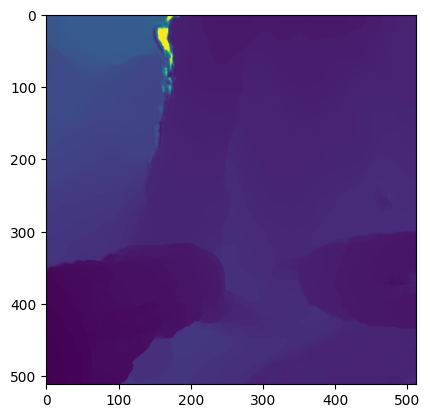

In [4]:
from skimage import io
import matplotlib.pyplot as plt
depth_image = io.imread('/home/a/Desktop/HK-Research/video-recovery/Data/seq1/depth/0257.png')
plt.imshow(depth_image)
plt.show()

In [31]:
 # Input
import numpy as np
x = np.linspace(-500, 500, 1001)

# Parameters:   m       b
line_params = [3.56, -25.36]
y = line_params[0] * x + line_params[1]
k = np.ones((len(y)-6,))
y_0 = k + y
params = [0,0]
J = np.empty(shape=(len(params),) + y_0.shape, dtype=np.float)
print(J.shape)

ValueError: operands could not be broadcast together with shapes (995,) (1001,) 

In [23]:
import random
import numpy as np
import numpy.linalg as la
h = 1
k = random.sample(range(0, 100), 30)
m = []
m.append([1,2,3])
m.append([3,4,5])
m = np.array(m,dtype=np.float32)
print(m.shape)
k = np.arange(24).reshape((-1,3))
print(k)
k / k[:, 2]

(2, 3)
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]
 [21 22 23]]


ValueError: operands could not be broadcast together with shapes (8,3) (8,) 

In [1]:

# feature matching
from numpy.linalg import inv
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from skimage import io
def stereo_matching(disp, tool_mask0, image_width, image_height, focal, baseline, K1_inv, file):
    l = 1
    x_base = np.tile(np.linspace(226, 737, image_width, dtype=np.float32), (l, image_height, 1)) \
            .reshape(l, 1, -1)
    y_base = np.tile(np.linspace(0, image_height - 1, image_height, dtype=np.float32), (l, image_width, 1)).transpose((0, 2, 1)) \
            .reshape(l, 1, -1)
    disp_t0 = disp[:512, 226:-2]
    depth_gt_t0 = np.tile(focal * baseline / (disp_t0 + 0.000001), (l, 1, 1, 1))
    depth = depth_gt_t0.reshape((image_height, image_width)).astype(np.uint8)
    depth = depth * tool_mask0
    io.imsave(file, depth)
    a = np.abs(depth_gt_t0 - np.roll(depth_gt_t0, 3, 2)) <= 1
    b = np.abs(depth_gt_t0 - np.roll(depth_gt_t0, -3, 2)) <= 1
    c = np.abs(depth_gt_t0 - np.roll(depth_gt_t0, 3, 3)) <= 1
    d = np.abs(depth_gt_t0 - np.roll(depth_gt_t0, -3, 3)) <= 1

    inline_t0 = (a.astype(int) + b.astype(int) + c.astype(int) + d.astype(int)) > 1
    inline_t0 = inline_t0.reshape(l, -1)
    depth_gt_t0 = depth_gt_t0.reshape(l, 1, -1)
    outlier_t0 = depth_gt_t0[:, 0, :] < 128
    outlier_t0 = outlier_t0 * inline_t0
    #print(outlier_t0.shape)
    outlier_t0 = (outlier_t0 * tool_mask0.reshape(l, -1))
    xy_gt_t0 = np.concatenate([x_base, y_base, np.ones_like(x_base, dtype=np.float32)], axis=1) * depth_gt_t0
    points_t0_gt = np.matmul(np.tile(K1_inv,(l, 1, 1)), xy_gt_t0).transpose((0, 2, 1))
    return points_t0_gt, outlier_t0

def feature_matching(template, image):
    # Initiate FAST object with default values
    fast = cv2.FastFeatureDetector_create()
    freak = cv2.xfeatures2d.FREAK_create()
    # find the keypoints
    kp_template = fast.detect(template, None)
    kp_image = fast.detect(image, None)
    # find descriptor
    des_kp_template, des_template = freak.compute(template, kp_template)
    des_kp_image, des_image = freak.compute(image, kp_image)
    # match features
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors.
    matches = bf.match(des_template, des_image)
    # Done: convert to 3D feature points
    src_pts = np.float32([m.pt for m in des_kp_template]).reshape(-1,2)
    dst_pts = np.float32([m.pt for m in des_kp_image]).reshape(-1,2)
    img3 = cv2.drawMatches(template,des_kp_template,image,des_kp_image,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #print(matches[0].queryIdx)
    plt.imshow(img3),plt.show()
    #pred_w_k = one_point_ransac(src_pts, dst_pts, matches, get_homography)
    return matches, src_pts, dst_pts

    

def get_homography(pts1, pts2):
    """Estimate the affine transformation between two lists of matching
    keypoint coordinates.
    
    Args:
    - pts1: List of (x, y) coordinates.
    - pts2: List of (x, y) coordinates.
    
    Returns:
    - t: 3x3 array representing the projective transformation matrix that
          maps `pts1` to `pts2`.
    """
    assert len(pts1) == len(pts2), \
        "`pts1` and `pts2` must have equal length."
    # Done
    A = []
    for i in range(len(pts1)):
        p1 = pts1[i]
        p2 = pts2[i]
        Ai1 = [p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1], -p2[0]]
        Ai2 = [0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1], -p2[1]]  
        A.append(Ai1)
        A.append(Ai2)
    
    A = np.array(A)
    _, _, vh = np.linalg.svd(A)
    t = vh[-1, :].reshape((3, 3))
    return t
'''
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')
'''

"\ndef write_ply(fn, verts, colors):\n    verts = verts.reshape(-1, 3)\n    colors = colors.reshape(-1, 3)\n    verts = np.hstack([verts, colors])\n    with open(fn, 'wb') as f:\n        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))\n        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')\n"

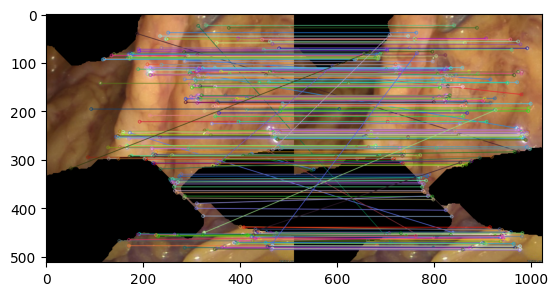

(1, 262144, 3) (1, 262144)
(163772, 3) (162456, 3)
[[ 0.61551588  0.25561326  0.74552134]
 [ 0.58379741 -0.24685208  0.77346276]
 [ 0.88114561  0.38744786 -0.27104716]
 ...
 [ 0.605538    0.79377597  0.05695125]
 [ 0.43332618  0.898969   -0.06389957]
 [ 0.81830044  0.39947123 -0.41328818]]
[[[ 23.79250717 -18.08851433  47.83826828]
  [ 23.57810402 -18.02449608  47.66896057]
  [ 23.73931313 -18.19797897  48.12776566]]

 [[  3.24688578 -16.84146881  44.70168304]
  [  3.48829222 -16.3183403   43.15673065]
  [  3.25618482 -16.33659935  43.20501709]]

 [[  3.32787728 -16.39477539  44.15627289]
  [  3.2735405  -16.4851284   44.23691559]
  [  3.26275301 -16.49100113  44.09109497]]

 ...

 [[ 21.11621094  15.15632915  47.40336227]
  [ 21.1188736   15.20485497  47.55513   ]
  [ 21.16313553  15.12513161  47.50870132]]

 [[ 21.17102242  15.14922714  47.38114548]
  [ 21.1188736   15.20485497  47.55513   ]
  [ 21.11621094  15.15632915  47.40336227]]

 [[ 21.81040764  15.27984715  47.78967285]
  [ 2

/Users/mikamixiao/miniconda3/envs/myvenv/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


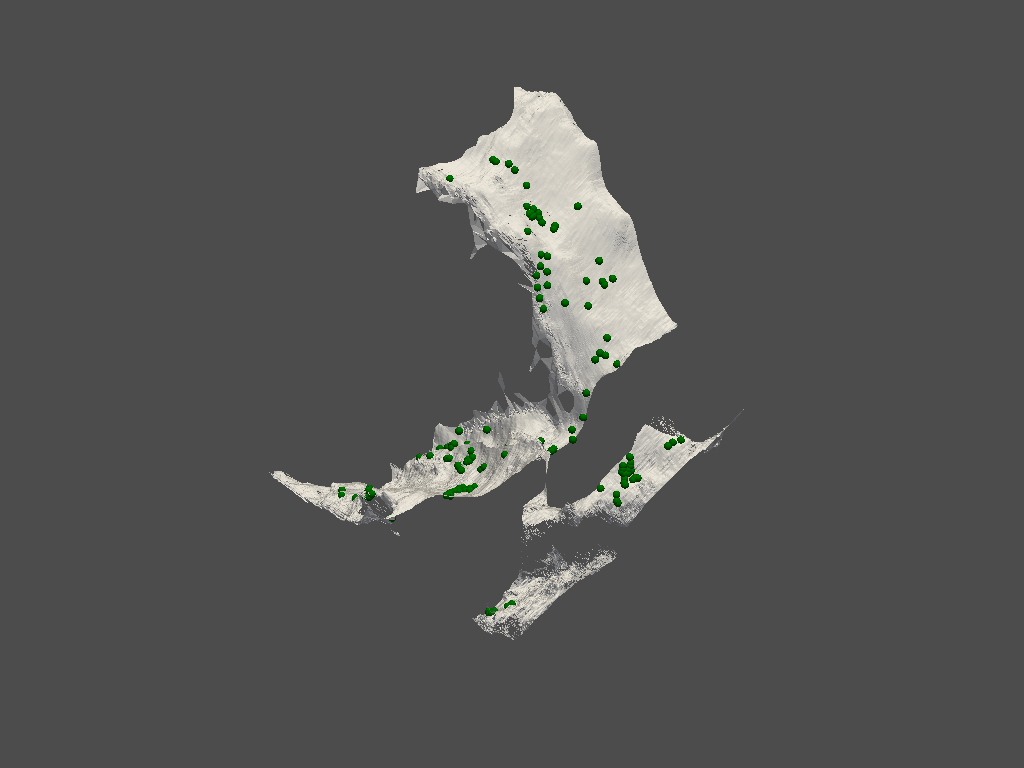

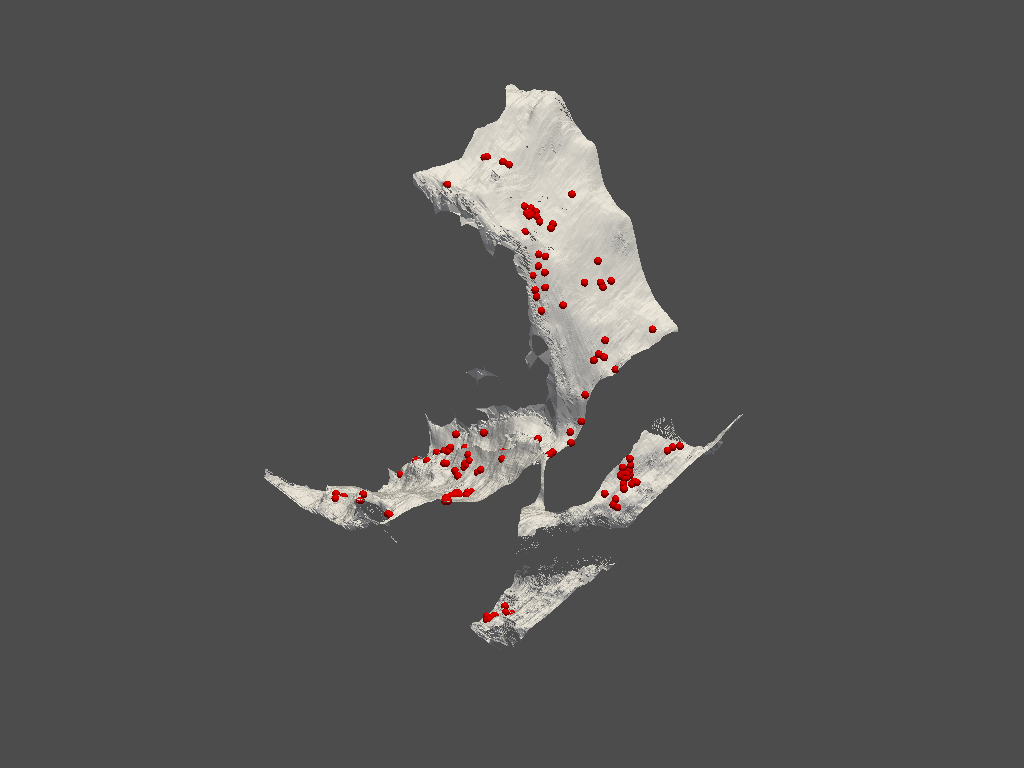

In [45]:
import pyvista as pv
import math
import trimesh
image1 = plt.imread('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/img_left/0257.jpg')
image2 = plt.imread('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/img_left/0258.jpg')
tool_mask0 = cv2.imread('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/tool/0257.png')
tool_mask1 = cv2.imread('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/tool/0258.png')
disp0 = np.load('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/disp/0257.npy')
disp1 = np.load('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/disp/0258.npy')
#cv2.IMREAD_GRAYSCALE
focal = 732.24990637
baseline = 4.552
l=1
K1 = np.array([[732.24990637, 0., 372.81334305],   
                                [0., 732.24990637, 276.87692261],
                                [0., 0., 1.]], dtype=np.float32)
K1_inv = inv(K1)
image_width = 512
image_height = 512
img1 = image1[0:512, 226:-2, :]
tool_mask0 = tool_mask0[0:512, 226:-2, :]
tool_mask1 = tool_mask1[0:512, 226:-2, :]
img2 = image2[0:512, 226:-2, :]
img1 = img1 * tool_mask0
img2 = img2 * tool_mask1
tool_mask0 = cv2.cvtColor(tool_mask0, cv2.COLOR_BGR2GRAY)
tool_mask1 = cv2.cvtColor(tool_mask1, cv2.COLOR_BGR2GRAY)
points0, outlier0 = stereo_matching(disp0, tool_mask0, 512, 512, focal, baseline, K1_inv)
points1, outlier1 = stereo_matching(disp1, tool_mask1, 512, 512, focal, baseline, K1_inv)
matches, src, dst = feature_matching(img1, img2)
src_points = []
dst_points = []
_3d_src_pts = []
_3d_dst_pts = []
_3d_src_out = []
_3d_dst_out = []
print(points0.shape, outlier0.shape)
for i in range(len(matches)):
    src_idx = matches[i].queryIdx
    dst_idx = matches[i].trainIdx
    src_points.append(src[src_idx, :])
    dst_points.append(dst[dst_idx, :])
    _3d_src_pts.append(points0[:,512*int(src_points[-1][0])+int(src_points[-1][1]),:])
    _3d_dst_pts.append(points1[:,512*int(dst_points[-1][0])+int(dst_points[-1][1]),:])
    #print(points0[:,512*int(src_points[-1][0])+int(src_points[-1][1]),:].shape)
    _3d_src_out.append(outlier0[:,512*int(src_points[-1][0])+int(src_points[-1][1])].astype(int))
    _3d_dst_out.append(outlier1[:,512*int(dst_points[-1][0])+int(dst_points[-1][1])].astype(int))


_3d_src_pts = np.array(_3d_src_pts)
_3d_src_out = np.array(_3d_src_out).reshape(-1)
_3d_dst_out = np.array(_3d_dst_out).reshape(-1)
_3d_src_inliner = (_3d_src_pts[_3d_src_out*_3d_dst_out == 1]).reshape((-1, 3))
_3d_dst_pts = np.array(_3d_dst_pts)
_3d_dst_inliner = (_3d_dst_pts[_3d_src_out*_3d_dst_out == 1]).reshape((-1, 3))
colors0 = img1.reshape(l, -1, 3)[:, outlier0[0] == 1, :]
colors1 = img2.reshape(l, -1, 3)[:, outlier1[0] == 1, :]
point0 = points0[:, outlier0[0] == 1, :].reshape(-1, 3)
point1 = points1[:, outlier1[0] == 1, :].reshape(-1, 3)
print(point0.shape, point1.shape)
#write_ply('out1.ply', point, colors)
#points = point.reshape(-1,3)
#print(points)
colors1 = colors1.reshape(-1,3)
colors0 = colors0.reshape(-1,3)
#point0 = np.vstack([point0, colors0])
#point1 = np.vstack([point1, colors1])
cloud0 = pv.PolyData(point0)
cloud1 = pv.PolyData(point1)
surf0 = cloud0.delaunay_2d(alpha=1.0)
surf1 = cloud1.delaunay_2d(alpha=1.0)
faces_as_array = surf0.faces.reshape((surf0.n_faces, 4))[:, 1:] 
tmesh = trimesh.Trimesh(surf0.points, faces_as_array)
print(tmesh.vertices.shape)
print(tmesh.vertex_normals.shape)
print(tmesh.triangles)
surf0 = surf0.compute_normals(consistent_normals=False)
print(surf1.faces, surf1.n_faces)
point_cloud = pv.PolyData(_3d_src_inliner)
point_cloud1 = pv.PolyData(_3d_dst_inliner)
plotter = pv.Plotter()
plotter.add_mesh(surf1)
plotter.add_mesh(point_cloud1, color='green', point_size=8.0, render_points_as_spheres=True)
plotter.show()

plotter1 = pv.Plotter()
plotter1.add_mesh(surf0)
plotter1.add_mesh(point_cloud, color='red', point_size=8.0, render_points_as_spheres=True)
plotter1.show()

In [ ]:
from simpleicp import PointCloud, SimpleICP
w_k_final = np.ones((_3d_dst_inliner.shape[0],), dtype=np.float32)
h=1
print(w_k_final.shape[0])
print(np.ones((w_k_final.shape[0], 1)).shape)
print(np.concatenate((_3d_dst_inliner, np.ones((w_k_final.shape[0], 1))), axis=1))
ref_src = _3d_src_inliner[15, :]
ref_dsr = _3d_dst_inliner[15, :]
ks1 = _3d_src_inliner - ref_src
ks2 = _3d_dst_inliner - ref_dsr
for i in range(10):
    w_k = np.ones((_3d_dst_inliner.shape[0],), dtype=np.float32)
    kp1 = ks1[w_k_final == 1]
    kp2 = ks2[w_k_final == 1] 
    p1 = PointCloud(kp1, columns=['x', 'y', 'z'])
    p2 = PointCloud(kp2, columns=['x', 'y', 'z'])
    print(p1.shape, p2.shape)
    icp = SimpleICP()
    icp.add_point_clouds(p1, p2)
    H, _, _ = icp.run(max_overlap_distance=1)
    R = H[:3,:3]
    d = np.sqrt(np.sum(np.power(ks2.T - R @ (ks1.T), 2), 0)).T
    index_update = (h/d) < 1
    w_k[index_update] = (h/d)[index_update]
    if np.sum(w_k) >= 10:
        w_k_final[w_k_final > w_k] = w_k[w_k_final > w_k]

w_k_final

In [9]:
import cv2
from LiDAA import *
from acc_test import *
import sys
sys.path.append(".")
plt.switch_backend('agg')

img11 = cv2.cvtColor(cv2.imread('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/img_left/0257.jpg'),cv2.COLOR_BGR2GRAY)
img22 = cv2.cvtColor(cv2.imread('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/img_left/0258.jpg'),cv2.COLOR_BGR2GRAY)
tool_mask0 = cv2.cvtColor(cv2.imread('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/tool/0257.png'),cv2.COLOR_BGR2GRAY)
tool_mask1 = cv2.cvtColor(cv2.imread('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/tool/0258.png'),cv2.COLOR_BGR2GRAY)
disp0 = np.load('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/disp/0257.npy')
disp1 = np.load('/Users/mikamixiao/Desktop/HK-Research/Video_recovery/Data/seq1/disp/0258.npy')
#cv2.IMREAD_GRAYSCALE
focal = 732.24990637
baseline = 4.552
l=1
image_width = 512
image_height = 512
img1 = img11[0:512, 226:-2]
tool_mask0 = tool_mask0[0:512, 226:-2]
tool_mask1 = tool_mask1[0:512, 226:-2]
img2 = img22[0:512, 226:-2]
img1 = img1 * tool_mask0
img2 = img2 * tool_mask1

CosProxThres = 0.4
SignAlingThres = 4000
total, good_HC, ET_KP, ET_M = siftAID(img1,img2, MatchingThres = SignAlingThres, Simi = 'SignProx', Visual=True)


asift_KPlist1, patches1, GT_Avec_list, asift_KPlist2, patches2 = load_acc_test_data('./acc-test/notredame')
good2_asift = [cv2.DMatch(i, i, 0.9) for i in range(0,len(asift_KPlist1))]
img3 = cv2.drawMatches(img1,asift_KPlist1,img2,asift_KPlist2,good2_asift, None,flags=2)
#cv2.imwrite('./temp/ARootSIFT_homography_matches.png',img3)

ModuleNotFoundError: No module named 'LiDAA'

In [1]:
from builtins import map
from multiprocessing.pool import ThreadPool

def stereo_matching(disp, tool_mask0, image_width, image_height, focal, baseline, K1_inv):
    l = 1
    x_base = np.tile(np.linspace(226, 737, image_width, dtype=np.float32), (l, image_height, 1)) \
            .reshape(l, 1, -1)
    y_base = np.tile(np.linspace(0, image_height - 1, image_height, dtype=np.float32), (l, image_width, 1)).transpose((0, 2, 1)) \
            .reshape(l, 1, -1)
    disp_t0 = disp[:512, 226:-2]
    depth_gt_t0 = np.tile(focal * baseline / (disp_t0 + 0.000001), (l, 1, 1, 1))
    a = np.abs(depth_gt_t0 - np.roll(depth_gt_t0, 3, 2)) <= 1
    b = np.abs(depth_gt_t0 - np.roll(depth_gt_t0, -3, 2)) <= 1
    c = np.abs(depth_gt_t0 - np.roll(depth_gt_t0, 3, 3)) <= 1
    d = np.abs(depth_gt_t0 - np.roll(depth_gt_t0, -3, 3)) <= 1

    inline_t0 = (a.astype(int) + b.astype(int) + c.astype(int) + d.astype(int)) > 1
    inline_t0 = inline_t0.reshape(l, -1)
    depth_gt_t0 = depth_gt_t0.reshape(l, 1, -1)
    outlier_t0 = depth_gt_t0[:, 0, :] < 128
    outlier_t0 = outlier_t0 * inline_t0
    outlier_t0 = (outlier_t0 * tool_mask0.reshape(l, -1))
    xy_gt_t0 = np.concatenate([x_base, y_base, np.ones_like(x_base, dtype=np.float32)], axis=1) * depth_gt_t0
    points_t0_gt = np.matmul(np.tile(K1_inv,(l, 1, 1)), xy_gt_t0).transpose((0, 2, 1))
    return points_t0_gt, outlier_t0

def find_3d(matches, src, dst, _3d_src, _3d_dst, _src_out, _dst_out):
    src_points = []
    dst_points = []
    _3d_src_pts = []
    _3d_dst_pts = []
    _3d_src_out = []
    _3d_dst_out = []
    src = np.clip(src, 0, 511)
    dst = np.clip(dst, 0, 511)
    for i in range(len(matches)):
        src_idx = matches[i].queryIdx
        dst_idx = matches[i].trainIdx
        src_points.append(src[src_idx, :])
        dst_points.append(dst[dst_idx, :])
        _3d_src_pts.append(_3d_src[:,512*int(src_points[-1][0])+int(src_points[-1][1]),:])
        _3d_dst_pts.append(_3d_dst[:,512*int(dst_points[-1][0])+int(dst_points[-1][1]),:])
        _3d_src_out.append(_src_out[:,512*int(src_points[-1][0])+int(src_points[-1][1])].astype(int))
        _3d_dst_out.append(_dst_out[:,512*int(dst_points[-1][0])+int(dst_points[-1][1])].astype(int))

    _3d_src_pts = np.array(_3d_src_pts)
    _3d_src_out = np.array(_3d_src_out).reshape(-1)
    _3d_dst_out = np.array(_3d_dst_out).reshape(-1)
    _3d_src_inliner = (_3d_src_pts[_3d_src_out*_3d_dst_out == 1]).reshape((-1, 3))
    _3d_dst_pts = np.array(_3d_dst_pts)
    _3d_dst_inliner = (_3d_dst_pts[_3d_src_out*_3d_dst_out == 1]).reshape((-1, 3))
    
    return _3d_src_inliner, _3d_dst_inliner


def affine_skew(tilt, phi, img, mask=None):
    '''
    affine_skew(tilt, phi, img, mask=None) -> skew_img, skew_mask, Ai
    Ai - is an affine transform matrix from skew_img to img
    '''
    h, w = img.shape[:2]
    if mask is None:
        mask = np.zeros((h, w), np.uint8)
        mask[:] = 255
    A = np.float32([[1, 0, 0], [0, 1, 0]])
    if phi != 0.0:
        phi = np.deg2rad(phi)
        s, c = np.sin(phi), np.cos(phi)
        A = np.float32([[c,-s], [ s, c]])
        corners = [[0, 0], [w, 0], [w, h], [0, h]]
        tcorners = np.int32( np.dot(corners, A.T) )
        x, y, w, h = cv2.boundingRect(tcorners.reshape(1,-1,2))
        A = np.hstack([A, [[-x], [-y]]])
        img = cv2.warpAffine(img, A, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    if tilt != 1.0:
        s = 0.8*np.sqrt(tilt*tilt-1)
        img = cv2.GaussianBlur(img, (0, 0), sigmaX=s, sigmaY=0.01)
        img = cv2.resize(img, (0, 0), fx=1.0/tilt, fy=1.0, interpolation=cv2.INTER_NEAREST)
        A[0] /= tilt
    if phi != 0.0 or tilt != 1.0:
        h, w = img.shape[:2]
        mask = cv2.warpAffine(mask, A, (w, h), flags=cv2.INTER_NEAREST)
    Ai = cv2.invertAffineTransform(A)
    return img, mask, Ai


def affine_detect(detector, des, img, mask=None, pool=None):
    '''
    affine_detect(detector, img, mask=None, pool=None) -> keypoints, descrs
    Apply a set of affine transformations to the image, detect keypoints and
    reproject them into initial image coordinates.
    See http://www.ipol.im/pub/algo/my_affine_sift/ for the details.
    ThreadPool object may be passed to speedup the computation.
    '''
    params = [(1.0, 0.0)]
    for t in 2**(0.5*np.arange(1,6)):
        for phi in np.arange(0, 180, 72.0 / t):
            params.append((t, phi))

    def f(p):
        t, phi = p
        timg, tmask, Ai = affine_skew(t, phi, img)
        kp = detector.detect(timg, tmask)
        keypoints, descrs = des.compute(timg, kp)
        for kp in keypoints:
            x, y = kp.pt
            kp.pt = tuple( np.dot(Ai, (x, y, 1)) )
        if descrs is None:
            descrs = []
        return keypoints, descrs

    keypoints, descrs = [], []
    if pool is None:
        ires = map(f, params)
    else:
        ires = map(f, params)

    for i, (k, d) in enumerate(ires):
        print('affine sampling: %d / %d\r' % (i+1, len(params)), end='')
        keypoints.extend(k)
        descrs.extend(d)

    print()
    return keypoints, np.array(descrs)



def feature_matching(template, image, type):
    if type == 'SIFT':
        sift = cv2.SIFT_create()
        kp_template, des_template = sift.detectAndCompute(template,None)
        kp_image, des_image = sift.detectAndCompute(image,None)
        # 4) Flann特征匹配
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des_template, des_image, k=2)
        goodMatch = []
        for m, n in matches:
            # goodMatch是经过筛选的优质配对，如果2个配对中第一匹配的距离小于第二匹配的距离的1/2，基本可以说明这个第一配对是两幅图像中独特的，不重复的特征点,可以保留。
            if m.distance < 0.50*n.distance:
                goodMatch.append(m)
        
        matches = goodMatch
    elif type == 'SURF':
        surf = cv2.xfeatures2d.SURF_create()
        kp_template, des_template = surf.detectAndCompute(template,None)
        kp_image, des_image = surf.detectAndCompute(image,None)
        # 4) Flann特征匹配
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des_template, des_image, k=2)
        goodMatch = []
        for m, n in matches:
            # goodMatch是经过筛选的优质配对，如果2个配对中第一匹配的距离小于第二匹配的距离的1/2，基本可以说明这个第一配对是两幅图像中独特的，不重复的特征点,可以保留。
            if m.distance < 0.50*n.distance:
                goodMatch.append(m)
        
        matches = goodMatch
    elif type == 'Affine':
        affine_feature = cv2.xfeatures2d.HarrisLaplaceFeatureDetector_create()
        affine_des = cv2.SIFT_create()
        #affine_descriptor = cv2.SIFT_create()
        affine_kpt1, affine_des1 = affine_detect(affine_feature, affine_des, template)
        #affine_kpt1, affine_des1 = affine.detectAndCompute(template, None)
        affine_kpt2, affine_des2 = affine_detect(affine_feature, affine_des, image)
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=100)

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(affine_des1, affine_des2, k=2)
        goodMatch = []
        for m, n in matches:
            # goodMatch是经过筛选的优质配对，如果2个配对中第一匹配的距离小于第二匹配的距离的1/2，基本可以说明这个第一配对是两幅图像中独特的，不重复的特征点,可以保留。
            if m.distance < 0.50*n.distance:
                goodMatch.append(m)
        matches = goodMatch
        kp_template = affine_kpt1
        kp_image = affine_kpt2
        img3 = cv2.drawMatches(template,kp_template,image,kp_image,goodMatch,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img3)
        plt.show()
    else:
        # Initiate FAST object with default values
        fast = cv2.FastFeatureDetector_create()
        freak = cv2.xfeatures2d.FREAK_create()
        # find the keypoints
        kp_template = fast.detect(template, None)
        kp_image = fast.detect(image, None)
        # find descriptor
        des_kp_template, des_template = freak.compute(template, kp_template)
        des_kp_image, des_image = freak.compute(image, kp_image)
        # match features
        # create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        # Match descriptors.
        matches = bf.match(des_template, des_image)
        # Done: convert to 3D feature points
        kp_template = des_kp_template
        kp_image = des_kp_image
    
    src_pts = np.float32([m.pt for m in kp_template]).reshape(-1,2)
    dst_pts = np.float32([m.pt for m in kp_image]).reshape(-1,2)
    return matches, src_pts, dst_pts

# try thin plate spline warping
def thin_plate_spline_warp(warped_pts, ctrl_pts, obj_to_warp):

    # convert everything to np array
    warped_pts = np.array(warped_pts)
    ctrl_pts = np.array(ctrl_pts)
    obj_to_warp = np.array(obj_to_warp)

    num_points = warped_pts.shape[0]
    K = np.zeros((num_points, num_points))
    for rr in np.arange(num_points):
        for cc in np.arange(num_points):
            K[rr,cc] = np.sum(np.subtract(warped_pts[rr,:], warped_pts[cc,:])**2) #R**2 
            K[cc,rr] = K[rr,cc]

    #calculate kernel function R
    K = np.maximum(K, 1e-320) 
    #K = K.* log(sqrt(K))
    K = np.sqrt(K) #
    # Calculate P matrix
    P = np.hstack((np.ones((num_points, 1)), warped_pts)) #nX4 for 3D
    # Calculate L matrix
    L_top = np.hstack((K, P))
    L_bot = np.hstack((P.T, np.zeros((4,4))))
    L = np.vstack((L_top, L_bot))

    param = np.matmul(np.linalg.pinv(L), np.vstack((ctrl_pts, np.zeros((4,3)))))

    # Calculate new coordinates (x',y',z') for each points 
    num_points_obj = obj_to_warp.shape[0]

    K = np.zeros((num_points_obj, num_points))
    gx = obj_to_warp[:,0]
    gy = obj_to_warp[:,1]
    gz = obj_to_warp[:,2]

    for nn in np.arange(num_points):
        K[:,nn] = np.square(np.subtract(gx, warped_pts[nn,0])) + \
        np.square(np.subtract(gy, warped_pts[nn,1])) + \
        np.square(np.subtract(gz, warped_pts[nn,2])) # R**2
 
    K = np.maximum(K, 1e-320) 
    K = np.sqrt(K) #|R| for 3D
    print(K)
    gx = np.vstack(obj_to_warp[:,0])
    gy = np.vstack(obj_to_warp[:,1])
    gz = np.vstack(obj_to_warp[:,2])
    P = np.hstack((np.ones((num_points_obj,1)), gx, gy, gz))
    L = np.hstack((K, P))
    print(L)
    object_warped = np.matmul(L, param)
    object_warped1 = np.zeros_like(obj_to_warp)
    print(object_warped)
    object_warped1[:,0] = np.round(object_warped[:,0]*10**3)*10**-3
    object_warped1[:,1] = np.round(object_warped[:,1]*10**3)*10**-3
    object_warped1[:,2] = np.round(object_warped[:,2]*10**3)*10**-3
    print(L.shape, param.shape)
    return np.float32(param), np.float32(object_warped)

def sampling(source, target):
    sourcecloud = o3d.geometry.PointCloud()
    targetcloud = o3d.geometry.PointCloud() 
    sourcecloud.points = o3d.utility.Vector3dVector(source) 
    targetcloud.points = o3d.utility.Vector3dVector(target) 
    source_tetra_mesh, source_pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(sourcecloud)
    target_tetra_mesh, target_pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(targetcloud)
    sourcemesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd=sourcecloud, alpha=10.0, tetra_mesh=source_tetra_mesh, pt_map=source_pt_map)
    targetmesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd=targetcloud, alpha=10.0, tetra_mesh=target_tetra_mesh, pt_map=target_pt_map)
    #sourcemesh = sourcemesh.as_open3d()
    #targetmesh = targetmesh.as_open3d()
    sourcepcd = sourcemesh.sample_points_uniformly(number_of_points=30000)
    targetpcd = targetmesh.sample_points_uniformly(number_of_points=30000)
    return np.asarray(sourcepcd.points, dtype=np.float32), np.asarray(targetpcd.points, dtype=np.float32), sourcepcd, targetpcd


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import numpy as np
import open3d as o3d
import imageio.v3 as iio
import pyvista as pv
import trimesh
import torch as th

img11 = cv2.imread('/home/a/Desktop/HK-Research/video-recovery/Data/seq1/img_left/0257.jpg')
img22 = cv2.imread('/home/a/Desktop/HK-Research/video-recovery/Data/seq1/img_left/0258.jpg')
tool_mask0 = cv2.imread('/home/a/Desktop/HK-Research/video-recovery/Data/seq1/tool/0257.png')
tool_mask1 = cv2.imread('/home/a/Desktop/HK-Research/video-recovery/Data/seq1/tool/0258.png')
disp0 = np.load('/home/a/Desktop/HK-Research/video-recovery/Data/seq1/disp/0257.npy')
disp1 = np.load('/home/a/Desktop/HK-Research/video-recovery/Data/seq1/disp/0258.npy')
#cv2.IMREAD_GRAYSCALE
focal = 732.24990637
baseline = 4.552
l=1
K1 = np.array([[732.24990637, 0., 372.81334305],   
                                [0., 732.24990637, 276.87692261],
                                [0., 0., 1.]], dtype=np.float32)
K1_inv = inv(K1)
image_width = 512
image_height = 512
img1 = img11[0:512, 226:-2,:]
tool_mask0 = tool_mask0[0:512, 226:-2,:]
tool_mask1 = tool_mask1[0:512, 226:-2,:]
img2 = img22[0:512, 226:-2,:]
img1 = img1 * tool_mask0
img2 = img2 * tool_mask1
tool_mask0 = cv2.cvtColor(tool_mask0, cv2.COLOR_BGR2GRAY)
tool_mask1 = cv2.cvtColor(tool_mask1, cv2.COLOR_BGR2GRAY)
_3d_src, _src_out = stereo_matching(disp0, tool_mask0, image_width, image_height, focal, baseline, K1_inv)
_3d_dst, _dst_out = stereo_matching(disp1, tool_mask1, image_width, image_height, focal, baseline, K1_inv)
matches, src_orb, dst_orb = feature_matching(img1, img2, 'Affine')
import numpy as np
import numbers
from warnings import warn


def initialize_sigma2(X, Y):
    """
    Initialize the variance (sigma2).
    Attributes
    ----------
    X: numpy array
        NxD array of points for target.
    
    Y: numpy array
        MxD array of points for source.
    
    Returns
    -------
    sigma2: float
        Initial variance.
    """
    (N, D) = X.shape
    (M, _) = Y.shape
    diff = X[None, :, :] - Y[:, None, :]
    err = diff ** 2
    return np.sum(err) / (D * M * N)

def lowrankQS(G, beta, num_eig, eig_fgt=False):
    """
    Calculate eigenvectors and eigenvalues of gaussian matrix G.
    
    !!!
    This function is a placeholder for implementing the fast
    gauss transform. It is not yet implemented.
    !!!
    Attributes
    ----------
    G: numpy array
        Gaussian kernel matrix.
    
    beta: float
        Width of the Gaussian kernel.
    
    num_eig: int
        Number of eigenvectors to use in lowrank calculation of G
    
    eig_fgt: bool
        If True, use fast gauss transform method to speed up. 
    """

    # if we do not use FGT we construct affinity matrix G and find the
    # first eigenvectors/values directly

    if eig_fgt is False:
        S, Q = np.linalg.eigh(G)
        eig_indices = list(np.argsort(np.abs(S))[::-1][:num_eig])
        Q = Q[:, eig_indices]  # eigenvectors
        S = S[eig_indices]  # eigenvalues.

        return Q, S

    elif eig_fgt is True:
        raise Exception('Fast Gauss Transform Not Implemented!')

class EMRegistration(object):
    """
    Expectation maximization point cloud registration.
    Attributes
    ----------
    X: numpy array
        NxD array of target points.
    Y: numpy array
        MxD array of source points.
    TY: numpy array
        MxD array of transformed source points.
    sigma2: float (positive)
        Initial variance of the Gaussian mixture model.
    N: int
        Number of target points.
    M: int
        Number of source points.
    D: int
        Dimensionality of source and target points
    iteration: int
        The current iteration throughout registration.
    max_iterations: int
        Registration will terminate once the algorithm has taken this
        many iterations.
    tolerance: float (positive)
        Registration will terminate once the difference between
        consecutive objective function values falls within this tolerance.
    w: float (between 0 and 1)
        Contribution of the uniform distribution to account for outliers.
        Valid values span 0 (inclusive) and 1 (exclusive).
    q: float
        The objective function value that represents the misalignment between source
        and target point clouds.
    diff: float (positive)
        The absolute difference between the current and previous objective function values.
    P: numpy array
        MxN array of probabilities.
        P[m, n] represents the probability that the m-th source point
        corresponds to the n-th target point.
    Pt1: numpy array
        Nx1 column array.
        Multiplication result between the transpose of P and a column vector of all 1s.
    P1: numpy array
        Mx1 column array.
        Multiplication result between P and a column vector of all 1s.
    Np: float (positive)
        The sum of all elements in P.
    """

    def __init__(self, X, Y, sigma2=None, max_iterations=None, tolerance=None, w=None, *args, **kwargs):
        if type(X) is not np.ndarray or X.ndim != 2:
            raise ValueError(
                "The target point cloud (X) must be at a 2D numpy array.")

        if type(Y) is not np.ndarray or Y.ndim != 2:
            raise ValueError(
                "The source point cloud (Y) must be a 2D numpy array.")

        if X.shape[1] != Y.shape[1]:
            raise ValueError(
                "Both point clouds need to have the same number of dimensions.")

        if sigma2 is not None and (not isinstance(sigma2, numbers.Number) or sigma2 <= 0):
            raise ValueError(
                "Expected a positive value for sigma2 instead got: {}".format(sigma2))

        if max_iterations is not None and (not isinstance(max_iterations, numbers.Number) or max_iterations < 0):
            raise ValueError(
                "Expected a positive integer for max_iterations instead got: {}".format(max_iterations))
        elif isinstance(max_iterations, numbers.Number) and not isinstance(max_iterations, int):
            warn("Received a non-integer value for max_iterations: {}. Casting to integer.".format(max_iterations))
            max_iterations = int(max_iterations)

        if tolerance is not None and (not isinstance(tolerance, numbers.Number) or tolerance < 0):
            raise ValueError(
                "Expected a positive float for tolerance instead got: {}".format(tolerance))

        if w is not None and (not isinstance(w, numbers.Number) or w < 0 or w >= 1):
            raise ValueError(
                "Expected a value between 0 (inclusive) and 1 (exclusive) for w instead got: {}".format(w))

        self.X = X
        self.Y = Y
        self.TY = Y
        self.sigma2 = initialize_sigma2(X, Y) if sigma2 is None else sigma2
        (self.N, self.D) = self.X.shape
        (self.M, _) = self.Y.shape
        self.tolerance = 0.001 if tolerance is None else tolerance
        self.w = 0.0 if w is None else w
        self.max_iterations = 100 if max_iterations is None else max_iterations
        self.iteration = 0
        self.diff = np.inf
        self.q = np.inf
        self.P = np.zeros((self.M, self.N))
        self.Pt1 = np.zeros((self.N, ))
        self.P1 = np.zeros((self.M, ))
        self.PX = np.zeros((self.M, self.D))
        self.Np = 0

    def register(self, callback=lambda **kwargs: None):
        """
        Perform the EM registration.
        Attributes
        ----------
        callback: function
            A function that will be called after each iteration.
            Can be used to visualize the registration process.
        
        Returns
        -------
        self.TY: numpy array
            MxD array of transformed source points.
        
        registration_parameters:
            Returned params dependent on registration method used. 
        """
        self.transform_point_cloud()
        while self.iteration < self.max_iterations and self.diff > self.tolerance:
            self.iterate()
            if callable(callback):
                kwargs = {'iteration': self.iteration,
                          'error': self.q, 'X': self.X, 'Y': self.TY}
                callback(**kwargs)

        return self.TY, self.get_registration_parameters()

    def get_registration_parameters(self):
        """
        Placeholder for child classes.
        """
        raise NotImplementedError(
            "Registration parameters should be defined in child classes.")

    def update_transform(self):
        """
        Placeholder for child classes.
        """
        raise NotImplementedError(
            "Updating transform parameters should be defined in child classes.")

    def transform_point_cloud(self):
        """
        Placeholder for child classes.
        """
        raise NotImplementedError(
            "Updating the source point cloud should be defined in child classes.")

    def update_variance(self):
        """
        Placeholder for child classes.
        """
        raise NotImplementedError(
            "Updating the Gaussian variance for the mixture model should be defined in child classes.")

    def iterate(self):
        """
        Perform one iteration of the EM algorithm.
        """
        self.expectation()
        self.maximization()
        self.iteration += 1

    def expectation(self):
        """
        Compute the expectation step of the EM algorithm.
        """
        P = np.sum((self.X[None, :, :] - self.TY[:, None, :])**2, axis=2) # (M, N)
        P = np.exp(-P/(2*self.sigma2))
        c = (2*np.pi*self.sigma2)**(self.D/2)*self.w/(1. - self.w)*self.M/self.N

        den = np.sum(P, axis = 0, keepdims = True) # (1, N)
        den = np.clip(den, np.finfo(self.X.dtype).eps, None) + c

        self.P = np.divide(P, den)
        self.Pt1 = np.sum(self.P, axis=0)
        self.P1 = np.sum(self.P, axis=1)
        self.Np = np.sum(self.P1)
        self.PX = np.matmul(self.P, self.X)

    def maximization(self):
        """
        Compute the maximization step of the EM algorithm.
        """
        self.update_transform()
        self.transform_point_cloud()
        self.update_variance()
vol_y += err_y
vol_z += err_z
mgrid = th.meshgrid(vol_x, vol_y, vol_z)
volume_x = mgrid[0].reshape(l, 64, 64, 64)
volume_y = mgrid[1].reshape(l, 64, 64, 64)
volume_z = mgrid[2].reshape(l, 64, 64, 64)
volume = th.cat([volume_x, volume_y, volume_z], axis=3).numpy()

# 增加一个维度
#goodMatch = np.expand_dims(goodMatch, 1)
_3d_src_f, _3d_dst_f = find_3d(matches, src_orb, dst_orb, _3d_src, _3d_dst, _src_out, _dst_out)
_3d_src_in = _3d_src[:, _src_out[0] == 1, :].reshape(-1, 3)
_3d_dst_in = _3d_dst[:, _dst_out[0] == 1, :].reshape(-1, 3)
print(_src_out.shape, _dst_out.shape)
_3d_src_sample, _3d_dst_sample, srcpcd, targetpcd = sampling(_3d_src_in, _3d_dst_in)
print(_3d_src_sample.shape, _3d_dst_sample.shape)
o3d.visualization.draw_geometries([srcpcd])
o3d.visualization.draw_geometries([targetpcd])
param, warped = thin_plate_spline_warp(_3d_src_f, _3d_dst_f, _3d_src_in)
print(warped.shape)
#np.savez(f'param_{257}_{2581}.npz', param=param, warped=warped, src_ctl=_3d_src_f, dst_ctl=_3d_dst_f)


In [57]:
import numpy as np 
import torch as th

X = np.random.randn(5, 3).astype(np.float32)
x = th.from_numpy(X)
Y = np.random.randn(3, 3).astype(np.float32)
y = th.from_numpy(Y)
(N, D) = X.shape
(M, _) = Y.shape
diff = X[None, :, :] - X[:, None, :]
diff1 = x[None, :, :] - x[:, None, :]
err = diff ** 2
err1 = diff1 ** 2
err2 = th.square(diff1)
print(np.sum(err))
print(th.sum(err1))
print(th.sum(err2, 2))

121.024635
tensor(121.0246)
tensor([[ 0.0000, 11.0095,  2.9128,  4.8762,  3.6981],
        [11.0095,  0.0000,  8.1559,  9.2437,  5.8247],
        [ 2.9128,  8.1559,  0.0000,  0.4073,  6.5360],
        [ 4.8762,  9.2437,  0.4073,  0.0000,  7.8481],
        [ 3.6981,  5.8247,  6.5360,  7.8481,  0.0000]])


In [9]:
Z = X[None, :, :]
print(Z)
H = Y[:, None, :]
print(H)


[[[ 0.67467008  0.53737587  1.47059294]
  [-0.61347807 -0.19597633 -0.80601997]
  [ 1.17315662  0.10684656 -1.30040515]
  [ 0.18038362 -0.17166803 -0.10026464]
  [-0.61090707 -0.60964351  1.26554442]]]
[[[-0.16126979  0.46680118  0.5846933 ]]

 [[-0.18927119  0.48743358  0.4811493 ]]

 [[ 0.45056346  0.79965269  0.37784313]]]


In [64]:
def gaussian_kernel(X, beta, Y=None):
    if Y is None:
        Y = X
    diff = X[:, None, :] - Y[None, :,  :]
    diff = th.square(diff)
    diff = th.sum(diff, 2)
    return th.exp(-diff / (2 * beta**2))

In [97]:
X = th.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9],[10,11,12],[13,14,15]], dtype=th.float32)
Y = th.tensor([[1, 2, 3], [4, 5, 6]], dtype=th.float32)
beta = 2
G = gaussian_kernel(X=Y, beta=beta, Y=Y)
G1 = G.numpy().astype(np.float32)
W = (th.zeros_like(Y) + 2) * 10
W1 = W.numpy().astype(np.float32)

print(G.shape)
mm = np.dot(G1, W1)
mm1 = th.matmul(G, W)
print(mm)
print(mm1)
print(mm == mm1)

torch.Size([2, 2])
[[20.684362 20.684362 20.684362]
 [20.684362 20.684362 20.684362]]
tensor([[20.6844, 20.6844, 20.6844],
        [20.6844, 20.6844, 20.6844]])
False


In [101]:
a = np.random.randn(100,23)
np.transpose(a).shape

(23, 100)

In [129]:
a1 = np.random.randn(10, ).astype(np.float32)
a = th.from_numpy(a1)
b1 = np.random.randn(10, 3).astype(np.float32)
b = th.from_numpy(b1)

In [130]:
c = np.dot(np.diag(a1), b1)
print(c.shape)
d = th.mm(th.diag(a), b)
print(d.shape)

(10, 3)
torch.Size([10, 3])


In [23]:
import torch as th
A = th.randn(5, 5, dtype=th.complex128)
L, V = th.linalg.eig(A)
print(L)
sort = th.argsort(th.abs(L))
a = th.flip(sort, dims=(0,))[:2].tolist()
print(sort, type(a))
print
V[:, a]
L[a]

tensor([-2.4081-0.6384j, -1.2799+0.9558j, -0.1692-1.1907j,  1.0480-0.4912j,
         1.2296+0.8643j], dtype=torch.complex128)
tensor([3, 2, 4, 1, 0]) <class 'list'>


tensor([-2.4081-0.6384j, -1.2799+0.9558j], dtype=torch.complex128)